# Question 3

1. Given a start-point, a goal point, and two obstacles (defined in the provided code), implement the artificial potential field method to plan a collision-free trajectory from the starting point to the target point, while avoiding the two obstacles.
2. Visualize the planned trajectory, clearly showing the start point, target point, obstacles, and the path generated by your planner.

Notes:
- We have F(att) which is the force towards a goal, and F(rep), which is the force away from an object
- Adding these forces together we get Q(u) for a given [x,y] u
- Working out Q(u) and moving accordingly lets us move sufficiently away from obstacles while still moving towards the goal
- This is good because:
    - We don't need any global knowledge
    - We only need to know about where the GOAL and LOCAL OBSTACLES are
- There are some traps that can be gotten into if F(att) and F(repp) cancel each other out - in this case global planning may be required
- We can use GRADIENT DESCENT to find the q minimising U(q)
- IOW, from a given point, where can we go where we would get the minimum U(q)
- Remember that force is the negative of the gradient of potential

In [ ]:
# Import necessary python packages
import torch
import matplotlib.pyplot as plt

import time  # For logging execution time (used in report for evaluation)

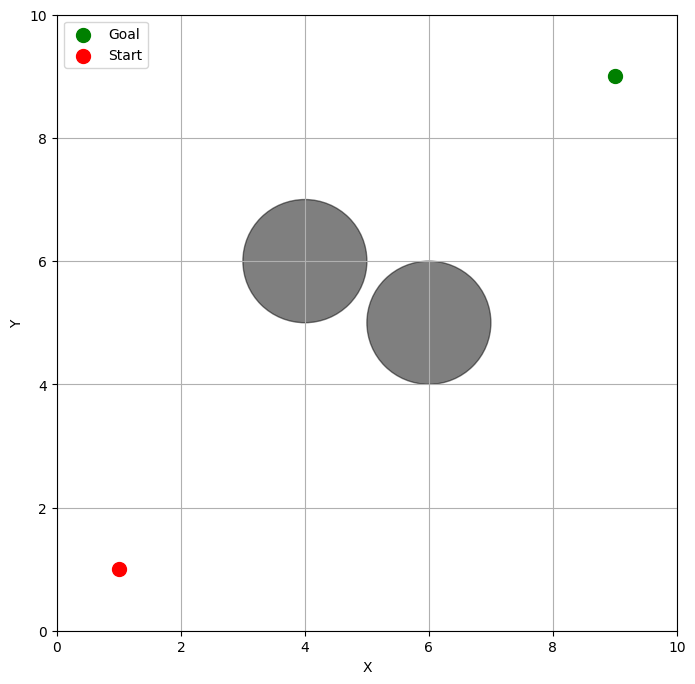

In [3]:
# Parameters for the environment
Goal = torch.tensor([9.0, 9.0], dtype=torch.float32)  # goal position
Start = torch.tensor([1.0, 1.0], dtype=torch.float32)  # start position

Obstacles = torch.tensor([[4.0, 6.0], [6.0, 5.0]], dtype=torch.float32)  # obstacle positions
Obstacle_radius = 1  # radius of the circular obstacles
Threshold = 4 # Threshold (i.e., rho_0), typically larger than Obstacle_radius
Constant_Parameter_K = 1

# Plotting the environment
plt.figure(figsize=(8, 8))
plt.scatter(Goal[0], Goal[1], color="green", label="Goal", s=100)
plt.scatter(Start[0], Start[1], color="red", label="Start", s=100)
for obs in Obstacles.numpy():
    circle = plt.Circle((obs[0], obs[1]), Obstacle_radius, color="black", alpha=0.5)
    plt.gca().add_artist(circle)
# Create a grid environment
grid_size = 10  # size of the grid
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [4]:
# Parameters for attractive force and repulsive force
k_att = 1.0  # attractive constant
k_rep = 100.0  # repulsive constant

# Calculate U_att(q), the attractive potential field (towards goal)
def attractive_potential(pos, goal):
    return 0.5 * k_att * torch.norm(pos - goal) ** 2

# Calculate U_rep(q), the repulsive potential field (away from obstacles)
def repulsive_potential(pos, obstacles, threshold):
    rep_total = 0
    for obs in obstacles:
        dist = torch.norm(pos - obs)
        if dist <= threshold:
            potential = 0.5 * k_rep * (1.0 / dist - 1.0 / threshold) ** 2
        else:
            potential = torch.tensor(0.0)  # zero if distance > threshold (means the robot is far from the obstacle)
        rep_total += potential
    return rep_total

# Calculate U(q), the total potential at any point (attr_pot + rep_pot)
def total_potential(pos, goal, obstacles, threshold):
    attr = attractive_potential(pos, goal)
    rep = repulsive_potential(pos, obstacles, threshold)
    return attr + rep

# Calculate ∇U(q), the gradient of U(q) using a given step size (a smaller step_size is more accurate)
# This can be used to find the force, since acting on the robot, since F(q) = −∇U(q)
def find_potential_gradient(pos, goal, obstacles, threshold, step_size):
    future_pos_x = torch.tensor([pos[0] + step_size, pos[1]])
    future_pos_y = torch.tensor([pos[0], pos[1] + step_size])
    # Store gradient as a vector [change in x relative to potential, change in y relative to potential]
    gradient = torch.tensor([0.0, 0.0])
    gradient[0] = (total_potential(future_pos_x, goal, obstacles, threshold) - total_potential(pos, goal, obstacles, threshold)) / step_size
    gradient[1] = (total_potential(future_pos_y, goal, obstacles, threshold) - total_potential(pos, goal, obstacles, threshold)) / step_size
    return gradient

In [5]:
# The force calculations below CAN be used - but are not totally necessary because F(q) = −∇U(q)
# We can find F(q) = −∇U(q) using solely the potential calculations

# Calculate F_att(q), the attractive force acting on the robot
def attractive_force(pos, goal):
    return -k_att * (pos - goal)

# Calculate F_rep(q), the repulsive force acting on the robot
def repulsive_force(pos, obstacles, threshold):
    force_total = torch.tensor([0.0, 0.0])
    for obs in obstacles:
        dist = torch.norm(pos - obs)
        if dist <= threshold:
            force = k_rep * ((1/dist) - (1/threshold)) * (1/(dist**2)) * ((pos-obs)/dist)
        else:
            force = torch.tensor(0.0)
        force_total += force
    return force_total

# Calculate F(q), the total force acting on the robot (attr_force + rep_force)
def total_force(pos, goal, obstacles, threshold):
    attr = attractive_force(pos, goal)
    rep = repulsive_force(pos, obstacles, threshold)
    return attr + rep

In [ ]:
# Set up constants
step_size = 0.0005 # step size for gradient calculation

alpha = 0.05 # learning rate

stopping_criteria = 0.1 # first stopping criteria - if x and y force goes below this, assume the goal has been reached
max_iterations = 1000000 # secondary stopping criteria - don't let iterations exceed this

current_pos = Start.clone()
current_pot_grad = find_potential_gradient(current_pos, Goal, Obstacles, Threshold, step_size)
trajectory = [current_pos.clone()]

# Record start time
start_time = time.time()

for i in range(0, max_iterations):
    current_pot_grad = find_potential_gradient(current_pos, Goal, Obstacles, Threshold, step_size)
    current_pos[0] = current_pos[0] - (alpha * current_pot_grad[0])
    current_pos[1] = current_pos[1] - (alpha * current_pot_grad[1])
    trajectory.append(current_pos.clone())
    # If both forces get smaller than the stopping criteria, stop
    if (-current_pot_grad[0] < stopping_criteria and -current_pot_grad[1] < stopping_criteria):
        print(trajectory)
        print(f"Done in {i} iterations")
        
        # Record end time - use with start time to calculate execution time
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Time taken: {elapsed_time:.4f} seconds")
        break

[tensor([1., 1.]), tensor([1.3990, 1.3990]), tensor([1.7786, 1.7786]), tensor([2.1387, 2.1387]), tensor([2.4812, 2.4812]), tensor([2.8059, 2.8040]), tensor([3.1072, 3.0954]), tensor([3.3754, 3.3399]), tensor([3.6070, 3.5272]), tensor([3.8006, 3.6478]), tensor([3.9593, 3.7058]), tensor([4.0891, 3.7182]), tensor([4.1973, 3.7050]), tensor([4.2867, 3.6777]), tensor([4.3632, 3.6443]), tensor([4.4300, 3.6091]), tensor([4.4901, 3.5730]), tensor([4.5458, 3.5368]), tensor([4.5992, 3.5019]), tensor([4.6507, 3.4675]), tensor([4.7024, 3.4342]), tensor([4.7539, 3.4014]), tensor([4.8065, 3.3689]), tensor([4.8610, 3.3365]), tensor([4.9183, 3.3048]), tensor([4.9780, 3.2724]), tensor([5.0415, 3.2402]), tensor([5.1092, 3.2081]), tensor([5.1822, 3.1761]), tensor([5.2606, 3.1437]), tensor([5.3463, 3.1118]), tensor([5.4395, 3.0807]), tensor([5.5422, 3.0521]), tensor([5.6543, 3.0254]), tensor([5.7775, 3.0025]), tensor([5.9126, 2.9846]), tensor([6.0606, 2.9735]), tensor([6.2216, 2.9716]), tensor([6.3953, 2.9

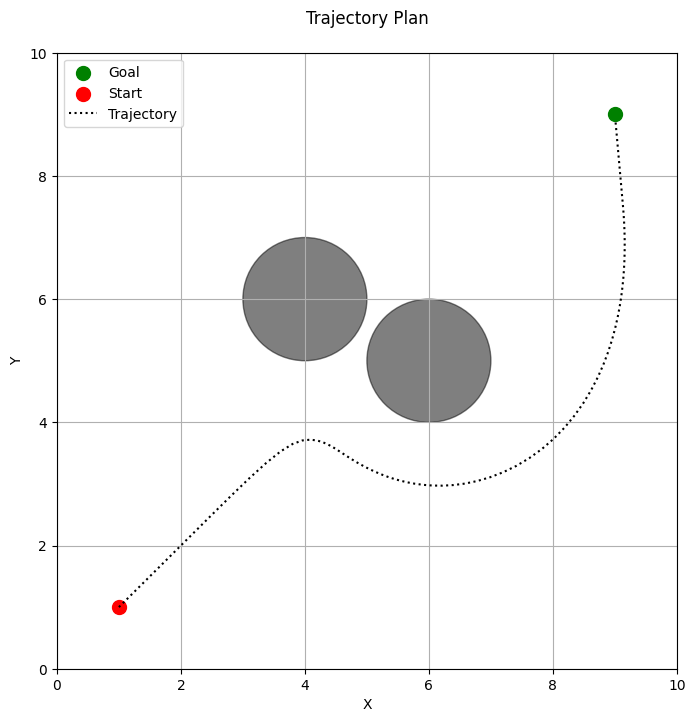

In [ ]:
# Plot the planned trajectory

# Parameters for the environment
Goal = torch.tensor([9.0, 9.0], dtype=torch.float32)  # goal position
Start = torch.tensor([1.0, 1.0], dtype=torch.float32)  # start position

Obstacles = torch.tensor([[4.0, 6.0], [6.0, 5.0]], dtype=torch.float32)  # obstacle positions
Obstacle_radius = 1  # radius of the circular obstacles
Threshold = 4 # threshold (i.e., rho_0), typically larger than Obstacle_radius
Constant_Parameter_K = 1

# Plotting the environment
plt.figure(figsize=(8, 8))
plt.scatter(Goal[0], Goal[1], color="green", label="Goal", s=100)
plt.scatter(Start[0], Start[1], color="red", label="Start", s=100)
for obs in Obstacles.numpy():
    circle = plt.Circle((obs[0], obs[1]), Obstacle_radius, color="black", alpha=0.5)
    plt.gca().add_artist(circle)

# Plotting the trajectory
x_vals = [pos[0].item() for pos in trajectory]
y_vals = [pos[1].item() for pos in trajectory]
plt.plot(x_vals, y_vals, color="black", label="Trajectory", linestyle="dotted")    

# Create a grid environment
grid_size = 10  # size of the grid
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Trajectory Plan\n")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Discuss the results in your report

Experiment with different step size or learning rate for gradient descent, evaluate their performance. Then, analyze and discuss your findings in the report. You do not need to write code for this section—focus on interpreting and explaining the results in your discussion.